In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import kagglehub
import os
import random
from IPython.display import Image as IM
import PIL
import pandas as pd

In [2]:
path = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mushrooms-classification-common-genuss-images' dataset.
Path to dataset files: /kaggle/input/mushrooms-classification-common-genuss-images


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cuda'

In [4]:
data_dir = os.path.join(path, 'Mushrooms')

In [5]:
def is_not_corrupted_image(path):
  try:
    with PIL.Image.open(path) as img:
      img.verify()
    with PIL.Image.open(path) as img:
      img.convert('RGB')
  except:
    return False
  return True

In [6]:
def make_weights_for_balanced_classes(images, nclasses):
    n_images = len(images)
    count_per_class = [0] * nclasses
    for _, image_class in images:
        count_per_class[image_class] += 1
    weight_per_class = [0.] * nclasses
    for i in range(nclasses):
        weight_per_class[i] = float(n_images) / float(count_per_class[i])
    weights = [0] * n_images
    for idx, (image, image_class) in enumerate(images):
        weights[idx] = weight_per_class[image_class]
    return weights

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
class ImageDataManager:
    def __init__(self, data_path, batch_size=32, img_size=224):
        self.data_path = data_path
        self.batch_size = batch_size
        self.img_size = img_size

        self.setup_transforms()
        self.load_and_split_data()
        self.create_sampler()
        self.create_dataloaders()

    def setup_transforms(self):
        self.train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(self.img_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.test_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def load_and_split_data(self):
        self.full_dataset = torchvision.datasets.ImageFolder(
            root=self.data_path,
            transform=self.train_transforms,
            is_valid_file=is_not_corrupted_image
        )
        targets = [sample[1] for sample in self.full_dataset.samples]

        train_indices, test_indices = train_test_split(
            range(len(self.full_dataset)),
            test_size=0.2,
            stratify=targets,
            random_state=42
        )

        self.train_indices = train_indices
        self.test_indices = test_indices

        self.train_dataset = Subset(self.full_dataset, train_indices)
        self.test_dataset = Subset(self.full_dataset, test_indices)

        original_dataset = self.test_dataset.dataset
        self.test_dataset.dataset = torchvision.datasets.ImageFolder(
            root=self.data_path,
            transform=self.test_transforms,
            is_valid_file=is_not_corrupted_image
        )

        print(f"Total classes: {len(self.full_dataset.classes)}")
        print(f"Train samples: {len(self.train_dataset)}")
        print(f"Test samples: {len(self.test_dataset)}")

        train_targets = [targets[i] for i in train_indices]
        test_targets = [targets[i] for i in test_indices]

        self.train_distribution = np.bincount(train_targets)
        self.test_distribution = np.bincount(test_targets)

        print(f"Train class distribution: {self.train_distribution}")
        print(f"Test class distribution: {self.test_distribution}")

    def create_sampler(self):
        targets = [self.full_dataset.targets[i] for i in self.train_indices]
        targets = torch.tensor(targets)

        class_counts = np.bincount(targets.numpy())
        class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

        sample_weights = class_weights[targets]

        self.train_sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

    def create_dataloaders(self):
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler=self.train_sampler,
        )

        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def get_class_names(self):
        return self.full_dataset.classes

data_manager = ImageDataManager(
    data_path= data_dir,
    batch_size=32
)

train_loader = data_manager.train_loader
test_loader = data_manager.test_loader
class_names = data_manager.get_class_names()

Total classes: 9
Train samples: 5370
Test samples: 1343
Train class distribution: [ 282  600  858  669  291  253 1250  918  249]
Test class distribution: [ 71 150 215 167  73  63 313 229  62]


Text(0.5, 1.0, 'Whole dataset distribution')

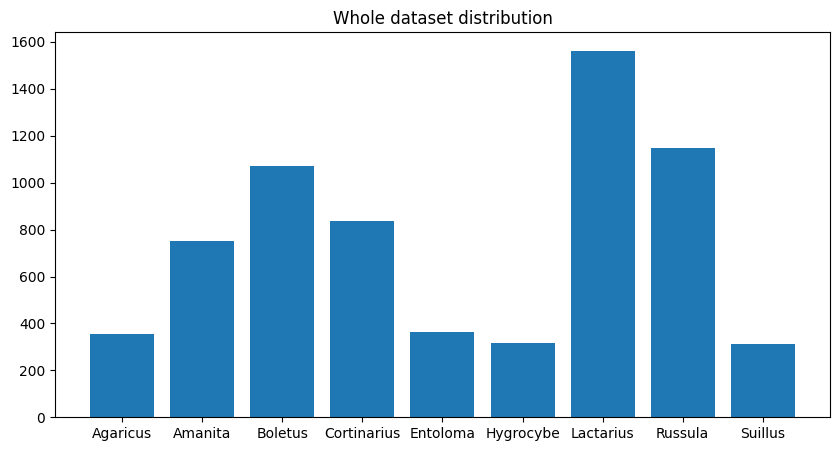

In [8]:
plt.figure(figsize=(10, 5))
plt.bar(data_manager.full_dataset.classes, data_manager.train_distribution + data_manager.test_distribution)
plt.title('Whole dataset distribution')

Text(0.5, 1.0, 'Test dataset distribution')

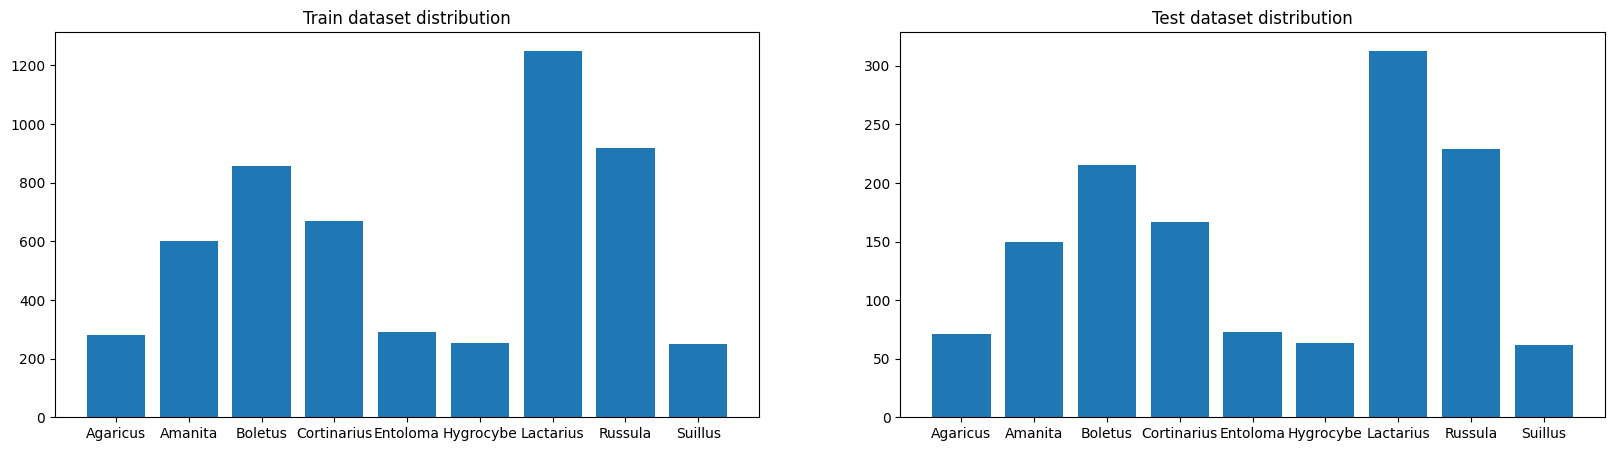

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.bar(data_manager.full_dataset.classes, data_manager.train_distribution)
ax1.set_title('Train dataset distribution')
ax2.bar(data_manager.full_dataset.classes, data_manager.test_distribution)
ax2.set_title('Test dataset distribution')

In [10]:
model = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
in_features = model.fc.in_features

In [12]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256, len(class_names))
    )

model = model.to(device)

In [13]:
#функция тренировки
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device='cuda'):
    model = model.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc='Training')
        for data, target in train_pbar:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            current_acc = 100. * train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })
        scheduler.step()
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        if val_loader != None:
          val_pbar = tqdm(val_loader, desc='Validation')
          with torch.no_grad():
              for data, target in val_pbar:
                  data, target = data.to(device), target.to(device)
                  output = model(data)
                  loss = criterion(output, target)

                  val_loss += loss.item()
                  _, predicted = torch.max(output.data, 1)
                  val_total += target.size(0)
                  val_correct += (predicted == target).sum().item()

                  current_acc = 100. * val_correct / val_total
                  val_pbar.set_postfix({
                      'Loss': f'{loss.item():.4f}',
                      'Acc': f'{current_acc:.2f}%'
                  })

          avg_train_loss = train_loss / len(train_loader)
          train_accuracy = 100. * train_correct / train_total
          if val_loader != None:
            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = 100. * val_correct / val_total

          history['train_loss'].append(avg_train_loss)
          history['train_accuracy'].append(train_accuracy)

          if val_loader != None:
            history['val_loss'].append(avg_val_loss)
            history['val_accuracy'].append(val_accuracy)

          print(f'Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.2f}%')
          if val_loader != None:
            print(f'Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.2f}%')
          print()

    return history

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
history = train(model, train_loader, test_loader, criterion, optimizer, scheduler, 10, device)

Epoch 1/10


Validation: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s, Loss=1.3560, Acc=62.17%]


Train Loss: 1.3693, Acc: 51.42%
Val Loss: 1.0409, Acc: 62.17%

Epoch 2/10


Validation: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s, Loss=0.8665, Acc=70.59%]


Train Loss: 1.1981, Acc: 57.90%
Val Loss: 0.8563, Acc: 70.59%

Epoch 3/10


Validation: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s, Loss=1.0188, Acc=67.46%]


Train Loss: 1.1276, Acc: 60.61%
Val Loss: 0.9161, Acc: 67.46%

Epoch 4/10


Validation: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s, Loss=0.9366, Acc=70.14%]


Train Loss: 1.1004, Acc: 61.17%
Val Loss: 0.8496, Acc: 70.14%

Epoch 5/10


Validation: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s, Loss=0.9142, Acc=71.03%]


Train Loss: 1.0999, Acc: 61.06%
Val Loss: 0.8276, Acc: 71.03%

Epoch 6/10


Validation: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s, Loss=0.7713, Acc=74.31%]


Train Loss: 1.0637, Acc: 62.81%
Val Loss: 0.7624, Acc: 74.31%

Epoch 7/10


Validation: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s, Loss=0.7318, Acc=75.65%]


Train Loss: 1.0299, Acc: 63.48%
Val Loss: 0.7406, Acc: 75.65%

Epoch 8/10


Validation: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s, Loss=0.6840, Acc=74.53%]


Train Loss: 0.9991, Acc: 65.31%
Val Loss: 0.7274, Acc: 74.53%

Epoch 9/10


Validation: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s, Loss=0.7090, Acc=74.68%]


Train Loss: 1.0158, Acc: 64.02%
Val Loss: 0.7326, Acc: 74.68%

Epoch 10/10


Validation: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s, Loss=0.7332, Acc=75.13%]

Train Loss: 0.9715, Acc: 66.20%
Val Loss: 0.7123, Acc: 75.13%



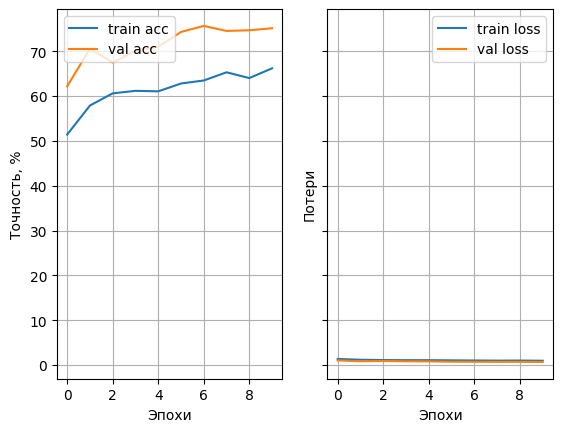

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
axes[0].plot(history["train_accuracy"], label="train acc")
axes[0].plot(history["val_accuracy"], label="val acc")
axes[0].set_xlabel('Эпохи')
axes[0].set_ylabel('Точность, %')
axes[0].grid(True)
axes[0].legend(loc="upper left")
axes[1].plot(history["train_loss"], label="train loss")
axes[1].plot(history["val_loss"], label="val loss")
axes[1].set_xlabel('Эпохи')
axes[1].set_ylabel('Потери')
axes[1].grid(True)
axes[1].legend(loc="upper right")
plt.show()

In [21]:
history = train(model, train_loader, test_loader, criterion, optimizer, scheduler, 5, device)

Epoch 1/5


Validation: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s, Loss=0.7271, Acc=75.06%]


Train Loss: 0.9853, Acc: 65.64%
Val Loss: 0.7178, Acc: 75.06%

Epoch 2/5


Validation: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s, Loss=0.6926, Acc=75.20%]


Train Loss: 0.9822, Acc: 66.07%
Val Loss: 0.7028, Acc: 75.20%

Epoch 3/5


Validation: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s, Loss=0.6995, Acc=75.95%]


Train Loss: 0.9675, Acc: 66.69%
Val Loss: 0.6917, Acc: 75.95%

Epoch 4/5


Validation: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s, Loss=0.6645, Acc=76.25%]


Train Loss: 0.9617, Acc: 66.24%
Val Loss: 0.6803, Acc: 76.25%

Epoch 5/5


Validation: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s, Loss=0.6833, Acc=75.20%]

Train Loss: 0.9577, Acc: 66.22%
Val Loss: 0.7080, Acc: 75.20%



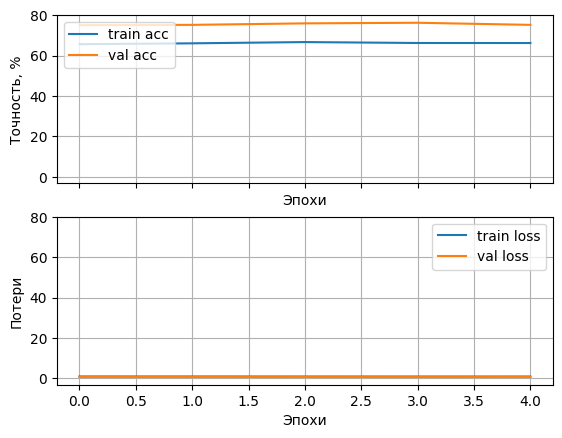

In [22]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].plot(history["train_accuracy"], label="train acc")
axes[0].plot(history["val_accuracy"], label="val acc")
axes[0].set_xlabel('Эпохи')
axes[0].set_ylabel('Точность, %')
axes[0].grid(True)
axes[0].legend(loc="upper left")
axes[1].plot(history["train_loss"], label="train loss")
axes[1].plot(history["val_loss"], label="val loss")
axes[1].set_xlabel('Эпохи')
axes[1].set_ylabel('Потери')
axes[1].grid(True)
axes[1].legend(loc="upper right")
plt.show()

In [23]:
def predict(model, data_loader, device='cuda'):
    model.eval()
    model.to(device)

    all_predictions = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(data_loader):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)


            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
    return np.array(all_predictions)

In [24]:
predictions = predict(model, test_loader, device)

In [25]:
all_targets = data_manager.test_dataset.dataset.targets
targets = [all_targets[i] for i in data_manager.test_dataset.indices]

In [26]:
accuracy = 0.
test_correct = 0.
test_correct += (predictions == targets).sum().item()
print(f"Accuracy: {100. * test_correct / len(predictions):.2f}%")

Accuracy: 75.20%


In [27]:
torch.save(model.state_dict(), "mushroom_weights.pth")
#model.load_state_dict(torch.load('mushroom_weights.pth'))
#model.eval()